# LIBRARIES & PACKAGES

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import math
from skimage import io

plt.rcParams['figure.figsize'] = [15, 5]

# FUNCTIONS

In [ ]:
def my_homography(keypoints_1, keypoints_2, matches):
  kp1_coord = [] # init array which will contain coordinates of matching points from query img
  kp2_coord = [] # init array which will contain coordinates of matching points from train img
  for i in range(len(matches)):
    kp1_coord.append(keypoints_1[matches[i].queryIdx].pt) # append coordinates of {i}-element of query img matching with train img
    kp2_coord.append(keypoints_2[matches[i].trainIdx].pt) # append coordinates of {i}-element of train img matching with train query
  H, _ = cv.findHomography(np.array(kp2_coord), np.array(kp1_coord),method=cv.RANSAC,
                           	ransacReprojThreshold = 3) # computing homography through 'findHomography',
                                                                                # passing the two arrays as param
                                                                                # I extract [0] element from 'H' obj.
                                                                                # RANSAC algorithm is chosen for homography computing,
                                                                                # (according to Prof. Bianco lectures)

  return H

In [ ]:
def my_warp(img2, H):

    shape = img2.shape
    if len(shape) == 3:
        height, width, _ = shape
    elif len(shape) == 2:
        height, width = shape

    result = cv.warpPerspective(img2, H, (width*2, height))
    return result


In [ ]:
def my_collage(base_img, img_to_add):
  non_zero_indices = np.argmax(base_img > 0, axis=1) # looking for the first non-zero pixel (different from black) for each row
  # print('non_zero_indices: ', non_zero_indices.T)       # for a better understanding, we can imagine at it like a column-vector in which
                                                        # each value is the x_index position of that pixel
  x_end = np.max(non_zero_indices) # choosing the highest value of non-zero x_index position, since it represents graphically the starting point
                                    # from which the warped image inclination due to the homography begins
  print('x_end: ', x_end)

  base_img[:, :x_end] = img_to_add[:, :x_end]  # updating warped image pixels with those of image1 (boat1), until the pixel where inclination begins

  plt.figure(figsize=(20, 10))
  plt.imshow(base_img, cmap='gray') # plotting the resulting stitched image in grayscale
  plt.xlim(0, 700)
  plt.show()

# MAIN

In [ ]:
drive.mount('/content/drive')
img_path = '/content/drive/MyDrive/Images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Image reading & plotting

I use `openCV` image reading module in order to read chosen images.
I use `matplotlib` instead for image showing.

In [ ]:
trees_1 = cv.imread(os.path.join(img_path, 'trees1.JPG'), 0)
trees_2 = cv.imread(os.path.join(img_path, 'trees2.JPG'), 0)

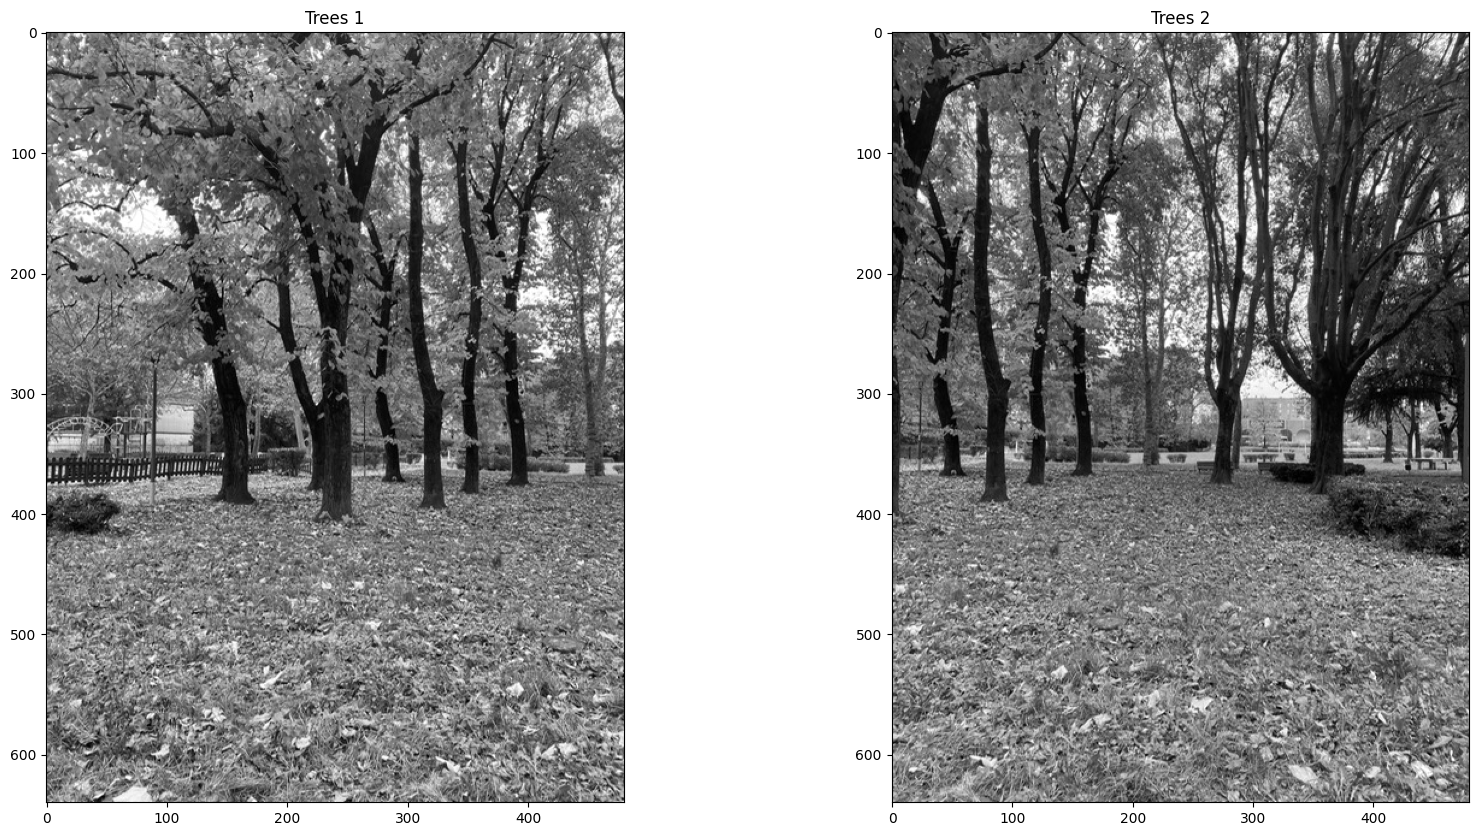

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(trees_1, cmap='gray')
axes[0].set_title('Trees 1')
axes[1].imshow(trees_2, cmap='gray')
axes[1].set_title('Trees 2')
plt.show()

## SIFT and MATCHER performing

In order to perform image blending for building a panoramic image, I need to extract the so-called keypoints and features from each of the two images.
This is a preliminary stage to train the Matcher, which will detect and link the corresponding keypoints.

In [ ]:
sift_trees = cv.SIFT_create() # inizializing an instance of SIFT builder
kp_trees1, ft_trees1 = sift_trees.detectAndCompute(trees_1, None) # extracting 'trees 1' image keypoints and features
kp_trees2, ft_trees2 = sift_trees.detectAndCompute(trees_2, None) # extracting 'trees 2' image keypoints and features
bf_trees = cv.BFMatcher_create(crossCheck=True) # inizializing an istance of Brute Force Matcher, in order to perform the feature matching between the two images
matches_trees = bf_trees.match(ft_trees1, ft_trees2)

In [ ]:
print("Number of extracted keypoints from the first image: ",len(kp_trees1))
print("Number of extracted keypoints from the second image: ",len(kp_trees2))
print("Number of matching keypoints: ",len(matches_trees))

Number of extracted keypoints from the first image:  5009
Number of extracted keypoints from the second image:  4726
Number of matching keypoints:  1949


It can be noticed that 5009 keypoints are detected from the first image, while 4726 are those extracted from the second one.<br>
The matching is based on 1949 keypoints.<br>
Below it can be seen the corresponding top 50 matches

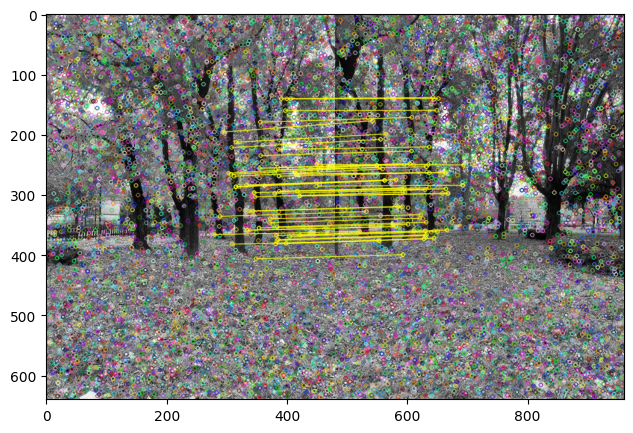

In [ ]:
matches_trees = sorted(matches_trees, key=lambda x: x.distance)
matching_kp = cv.drawMatches(trees_1, kp_trees1, trees_2, kp_trees2, matches_trees[0:50], None, matchColor=(255,255,0))
plt.imshow(matching_kp); plt.show()

## Homography computing

In order to blend the two images into a single one, a transformation function called homography needs to be computed. Homography allows the coordinates of the matching keypoints in the second image to be expressed as a function of a 3×3 matrix that multiplies the coordinates of the matching keypoints in the first image.

In [ ]:
H = my_homography(kp_trees1, kp_trees2, matches_trees)
print(H)

[[ 5.76855928e-01 -3.00759062e-03  2.41993794e+02]
 [-2.88790725e-01  8.60826563e-01  4.81512159e+01]
 [-8.25530805e-04 -5.60004619e-05  1.00000000e+00]]


## Image warping

The homography computed before has to be used for warping the second image, into the matching keypoints.<br>
The result will be a new image with slopped high boundaries due to the warping distorsion

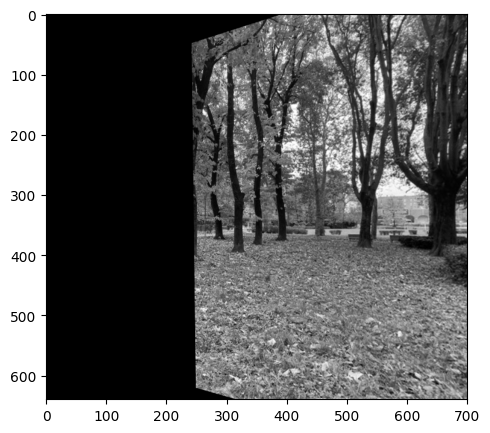

In [ ]:
trees_2_warped = my_warp(trees_2, H)
plt.imshow(trees_2_warped, cmap='gray')
plt.xlim(0,700)
plt.show()

## Image stitching

Once obtained the warped image, i need to join it with the first one.<br>
As described in `my_collage()` comment lines, this process is made by:
* detecting the vertical-rectangular warped image region, without slopped boundaries: that portion will be the actual image piece which will be attached to 'trees_1';
* the first image will occupy the black region which it is shown in the above plot, as well as the overlapping cut region from the warped image

x_end:  390


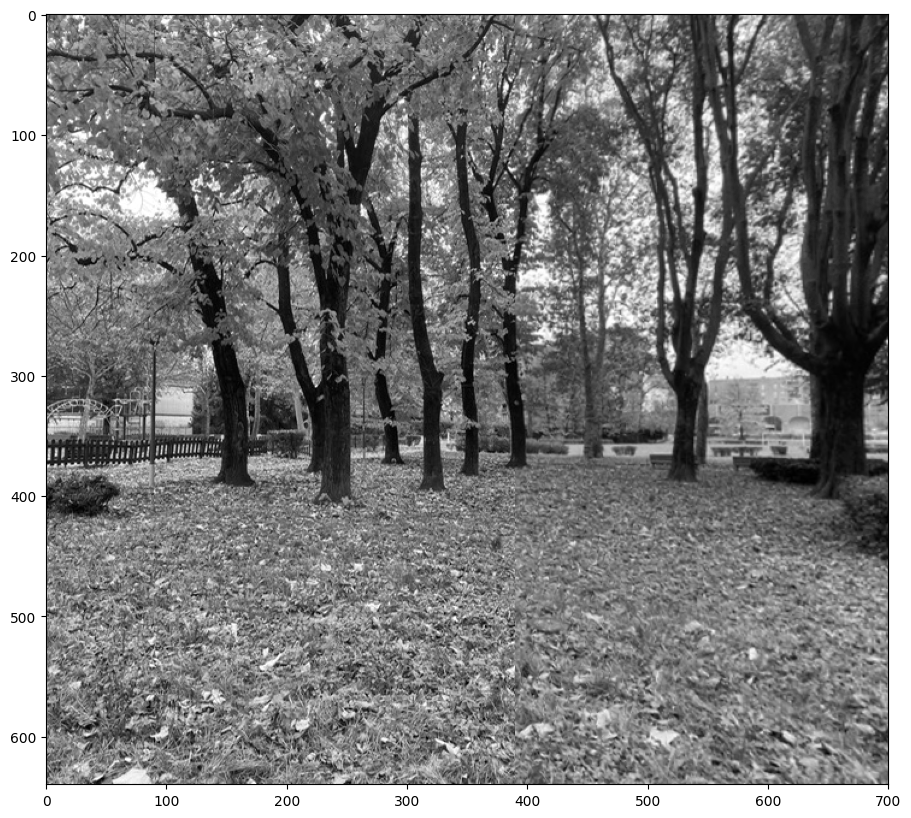

In [ ]:
 my_collage(trees_2_warped, trees_1)